## Forecasting Influenza-Like Illness in Kent County, Michigan

**Lillian Jensen**

---
**Research Question**

Does a county-specific time series model of ILI incidence with local syndromic data, Google search trends data, weather data, and air quality data have a statistically significant improvement on ILI prediction compared to historical trends alone?

**Datasets to be Used**

This analysis uses heterogeneous, multi-source data. Kent County ILI incidence data is from the Michigan Disease Surveillance System (MDSS), ED visits data is from the Michigan Syndromic Surveillance System (MSSS), historical air quality data is from a publicly available EPA database, search term trends come from Google’s Health Trends API, and climate data was sourced from the NOAA Climate Online Data Access.


---
*Setting up code environment*

In [1]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from epiweeks import Week, Year
from calendar import month_name
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as smt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

## Some helpful functions ##

def plot_ccf_sm(target, exog, unbiased=False, nlags=10):
    """Plot CCF using Statsmodels"""
    ccfs = smt.ccf(target, exog, unbiased=False)[:nlags+1]
    lags = np.arange(len(ccfs))[:nlags+1]
    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation (Statsmodels): {target.name} & {exog.name}")

def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation. 
    Shifted data (y) filled with NaNs 
    """
    return x.corr(y.shift(lag))


def plot_ccf_manual(target, exog, nlags=10):
    """PLot CCF using manual calculations"""
    lags = []
    ccfs = []
    for i in np.arange(0,nlags+1):
        lags.append(i)
        ccfs.append(crosscorr(target, exog, lag=i))

    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation (Manual): {target.name} & {exog.name}")

def difference(dataset, n):
    """ this function intakes a list of values, 
    subtracts the nth prior value,
    and returns the list of differenced values.
    """
    return pd.Series([dataset[i] - dataset[i - n] for i in range(1, len(dataset))])

def ADF(time_series, max_lags):
    t_stat, p_value, lags, _, critical_values, _ = adfuller(
    time_series,
    maxlag=max_lags
    )
    print(f'ADF Statistic: {t_stat:.2f}')
    print(f'p-value: {p_value:.2f}')
    print(f'lags: {lags}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')

In [217]:
df = pd.read_csv('data.csv', index_col=0)

In [218]:
fig = px.line(df['temp'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show()

---
Monthly means will be calculated for each continuous variable alongside box&whiskers plots to visualize variable spreads. 

In [219]:
df.columns

Index(['weekstart', 'cases', 'ed_visits', 'wind', 'precip', 'snow', 'temp',
       'aqi', 'co', 'ozone', 'pm10', 'pm25', 'no2', 'flu_ggl_searches',
       'cough_ggl_searches', 'cold_ggl_searches', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'top', 'Month'],
      dtype='object')

In [220]:
pretty_var_names = {
                    'cases'             :   'Cases',
                    'ed_visits'         :   'ED Visits',
                    'wind'              :   'Wind',
                    'precip'            :   'Precip. (in)',
                    'snow'              :   'Snowfall (in)',
                    'temp'              :   'Temp. (F)',
                    'aqi'               :   'AQI',
                    'flu_ggl_searches'  :   "'Flu' Searches",
                    'cough_ggl_searches':   "'Cough' Searches",
                    'cold_ggl_searches' :   "'Cold' Searches",
                    'co'                :   'CO',
                    'ozone'             :   'Ozone',
                    'pm10'              :   'PM10',
                    'pm25'              :   'PM2.5',
                    'no2'               :   'NO2',
                    'year'              :   'Year',
                    'top'               :   'Main Pollutant'
                    }

In [221]:
cont_vars = [
                'Cases', 'ED Visits', 'Wind', 'Precip. (in)', 
                'Snowfall (in)', 'Temp. (F)', 'AQI', 'CO','Ozone',
                'PM10', 'PM2.5', 'NO2', "'Flu' Searches", 
                "'Cough' Searches", "'Cold' Searches"
            ]

In [222]:
months_ordered = [
                'January', 'February', 'March', 
                'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 
                'November', 'December'
                ]

In [223]:
df = df.rename(columns=pretty_var_names)

In [224]:
def means_by_month_make_pretty(df_means: pd.DataFrame) -> pd.DataFrame:
    df = df_means.apply(lambda x: round(x,3))
    df = df.reset_index().rename(columns={'Month':'Variable'}).set_index('Variable')
    df = df.rename(columns=pretty_var_names)
    df = df.T
    return df

In [228]:
cases_variables = ['Cases','ED Visits']
weather_variables = ['Wind','Precip. (in)','Snowfall (in)','Temp. (F)']
airquality_variables = ['AQI','CO','Ozone','PM10','PM2.5','NO2']
google_variables = ["'Flu' Searches","'Cough' Searches","'Cold' Searches"]

In [230]:
df_cont_vars_and_month = df.set_index('weekstart')[cont_vars+['Month']]
df_monthly_means = df_cont_vars_and_month.groupby('Month').mean()

pretty_means = means_by_month_make_pretty(df_monthly_means)
pretty_means = pretty_means[months_ordered]
for var in [cases_variables,weather_variables,airquality_variables,google_variables]:
    print(tabulate(pretty_means.T[var], headers=var))
    print('')


              Cases    ED Visits
---------  --------  -----------
January    1719.95       108.065
February   1842.25       125.768
March      1729.71       112.968
April       874.59        66.492
May         864.59        57
June        150.4         35.117
July          4.906       27.906
August       29.185       27.246
September   741.8         46.092
October    1412.2         77.848
November   1246.33        74.656
December   1016.7        112.078

             Wind    Precip. (in)    Snowfall (in)    Temp. (F)
---------  ------  --------------  ---------------  -----------
January    10.226           0.098            0.766       24.077
February   10.357           0.099            0.657       25.667
March      10.194           0.08             0.112       34.964
April      10.77            0.165            0.077       48.1
May         8.852           0.124            0           61.467
June        8.15            0.149            0           69.419
July        7.453           0.1

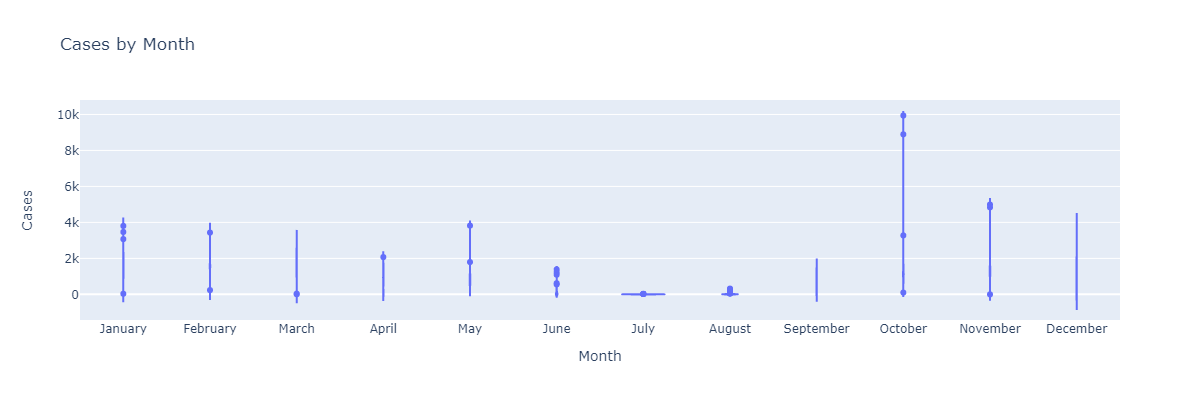

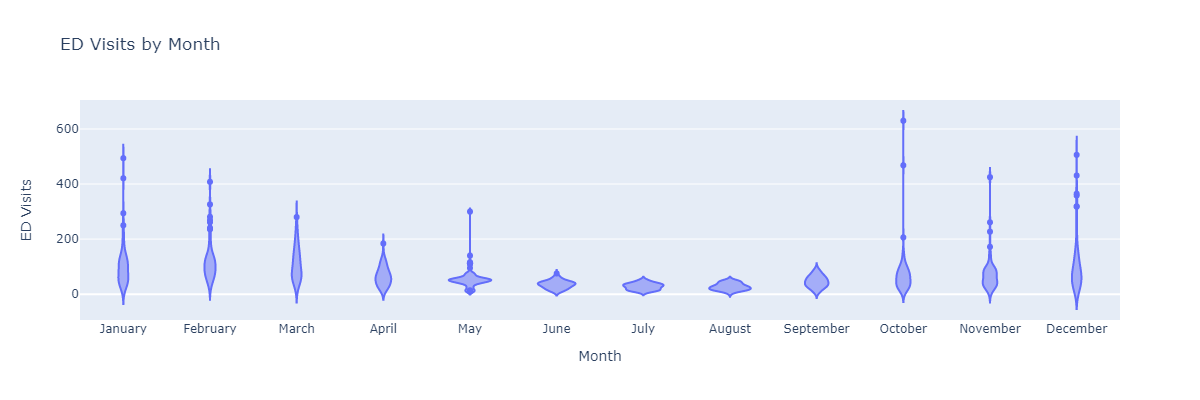

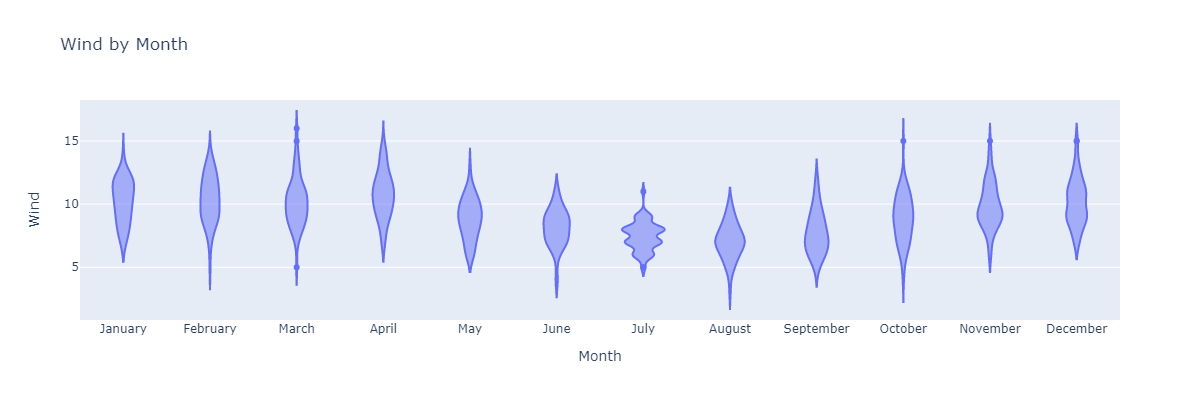

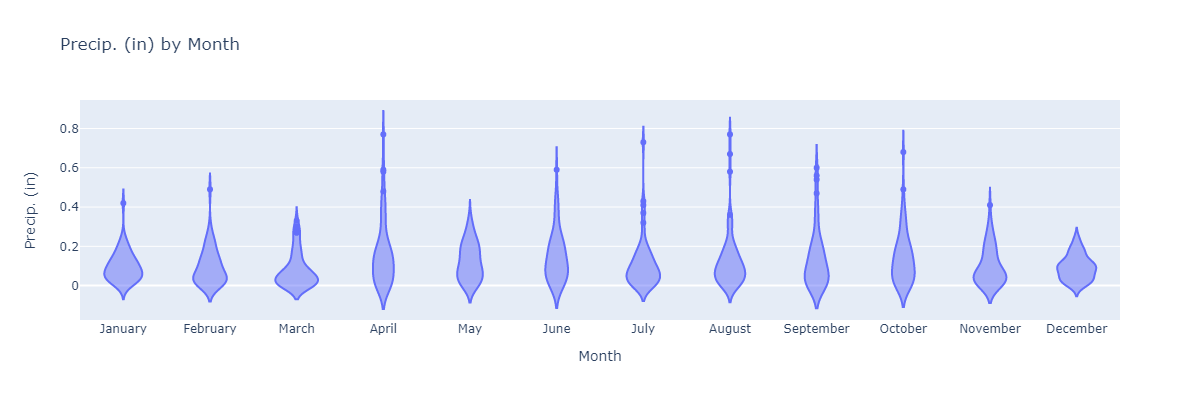

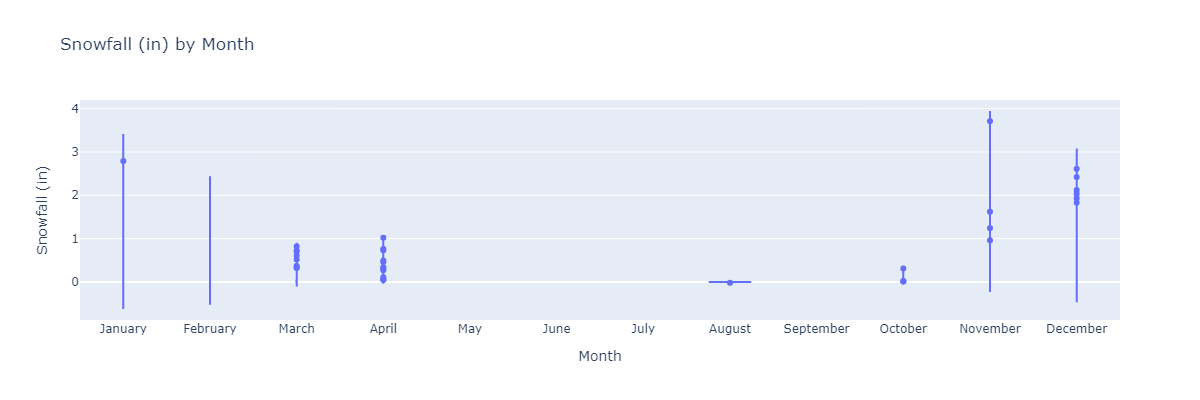

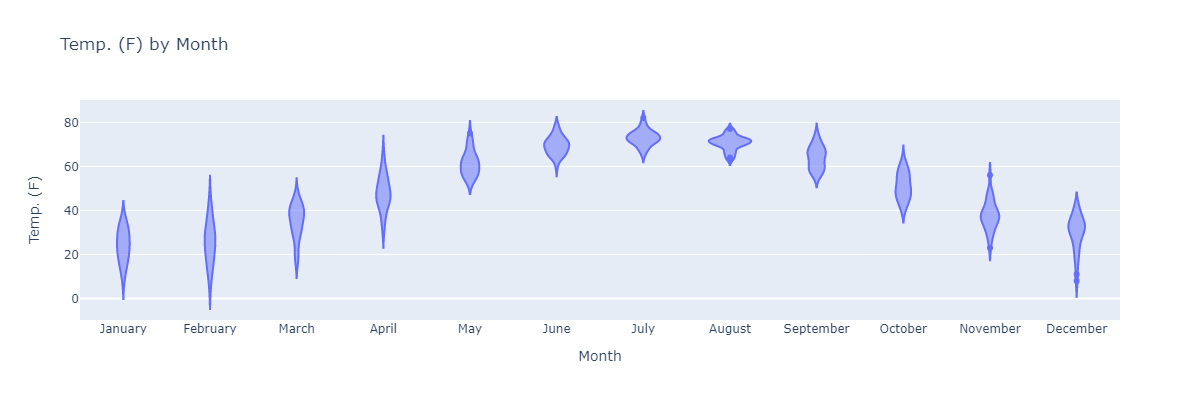

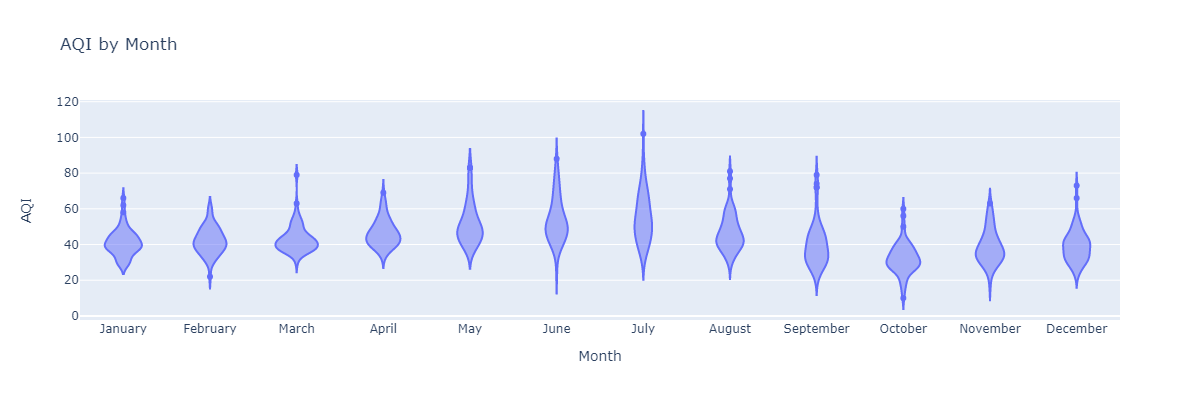

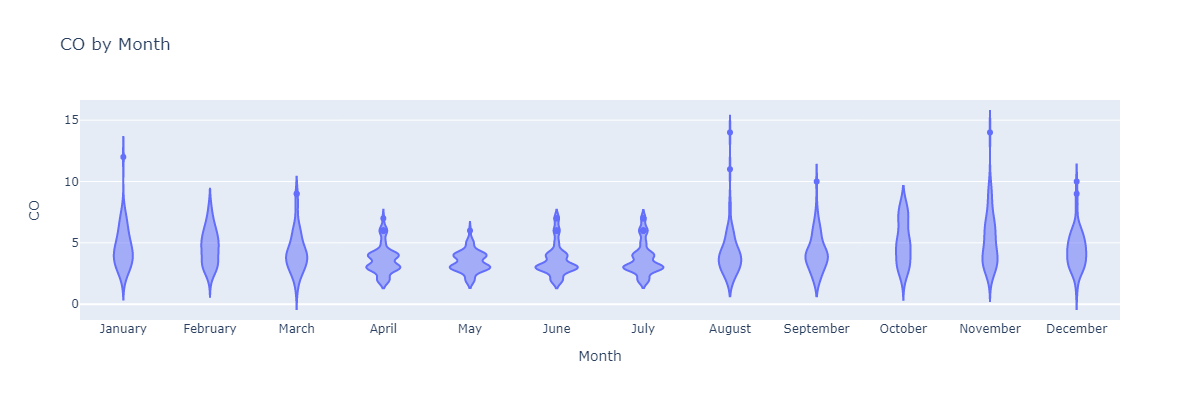

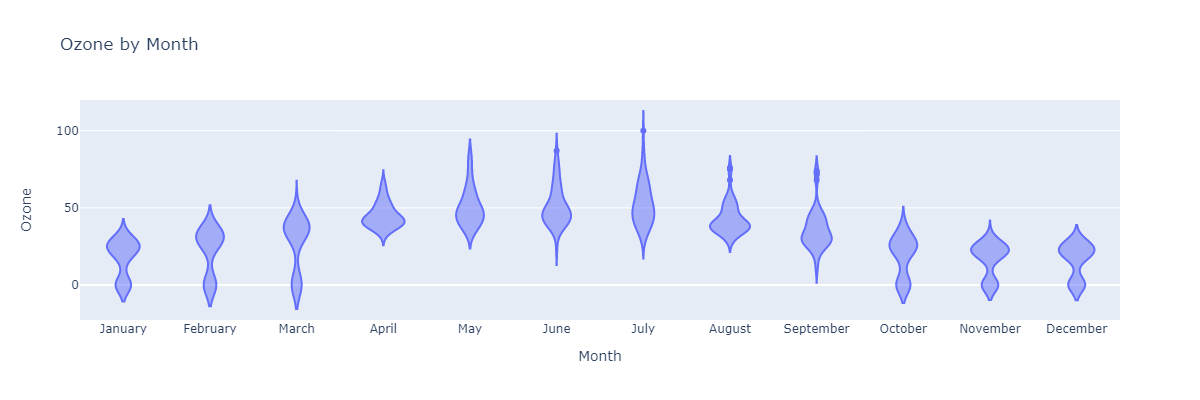

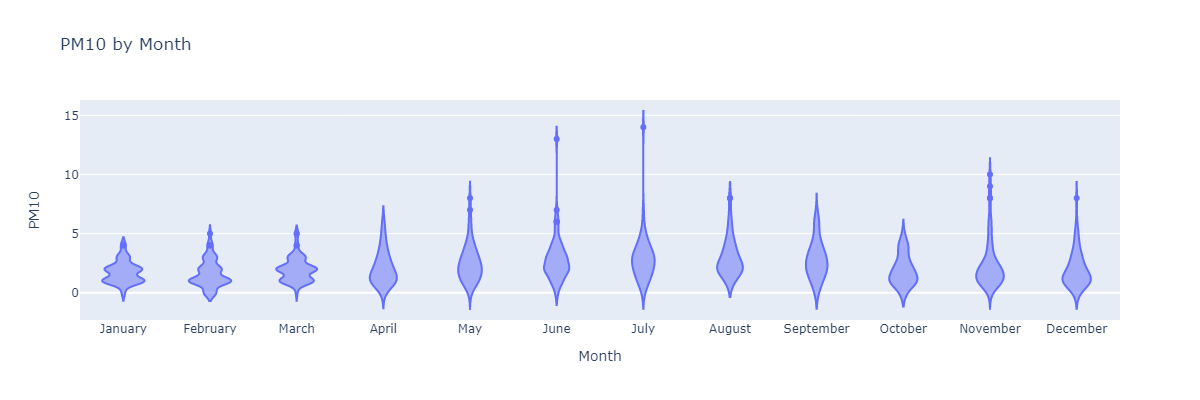

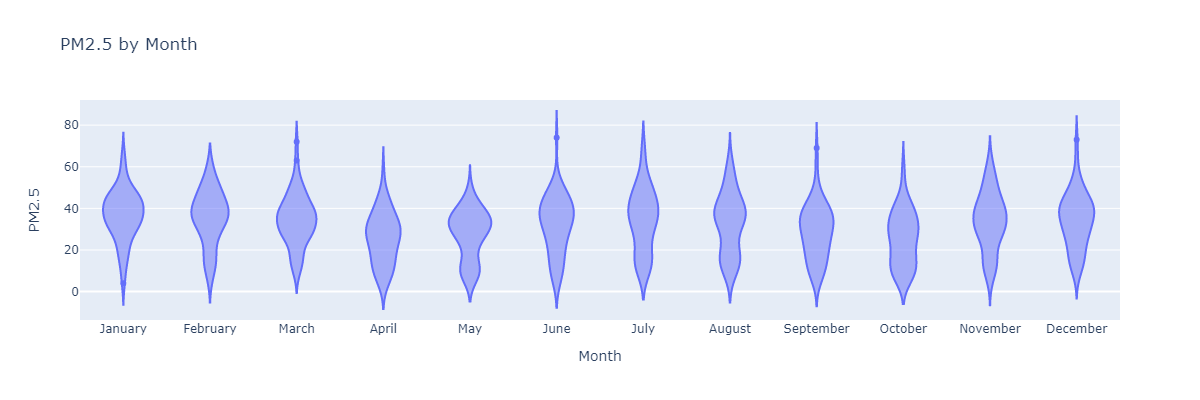

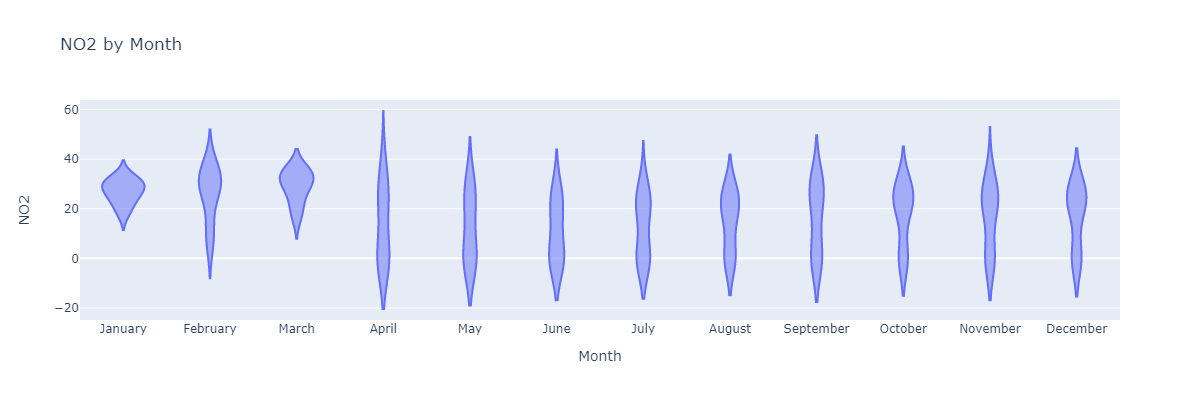

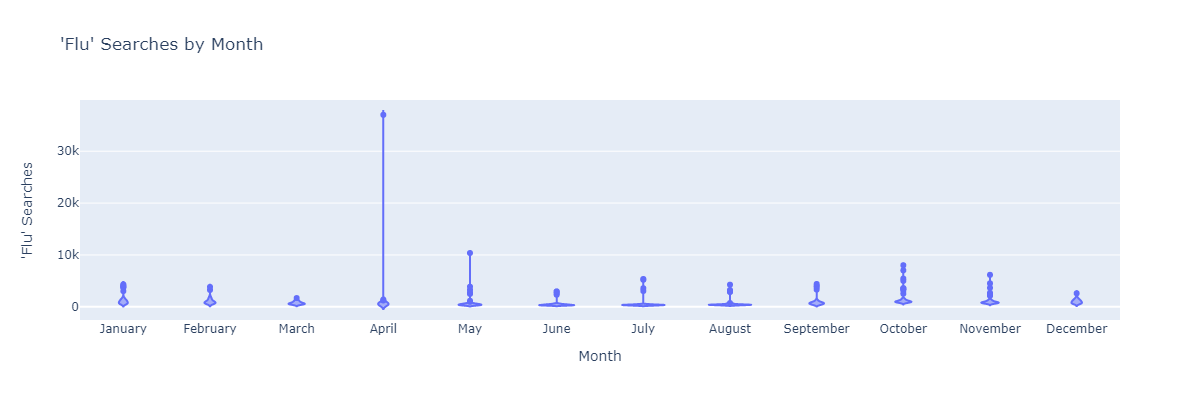

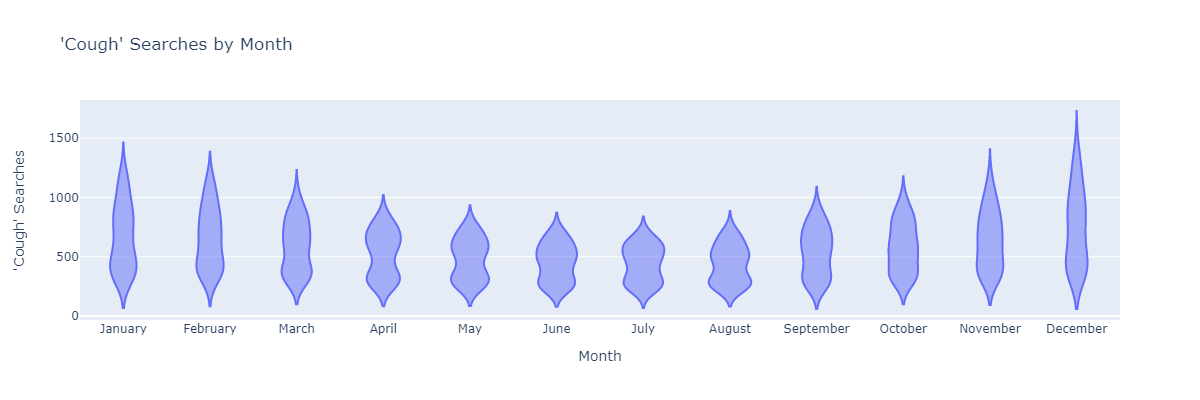

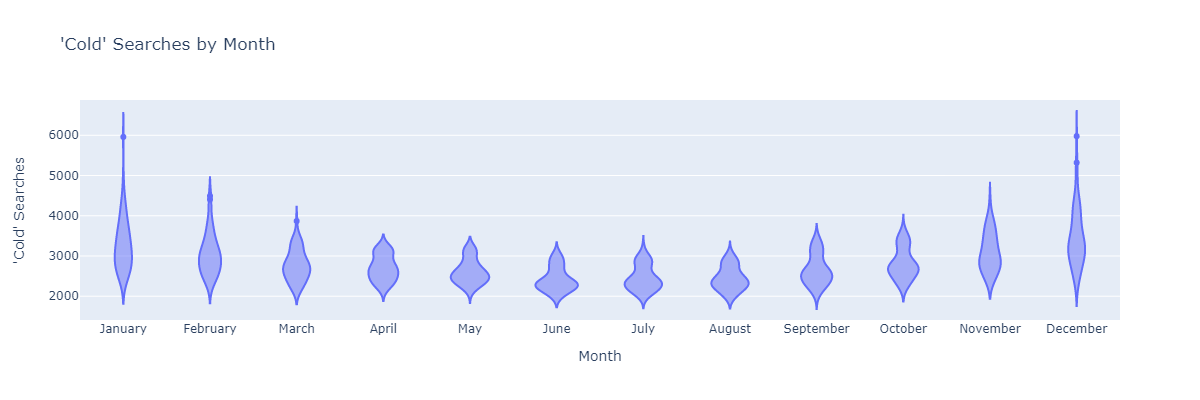

In [231]:
for var in cont_vars:
    fig = px.violin(df_cont_vars_and_month, x = 'Month', y = var, title=f'{var} by Month')
    fig.update_xaxes(categoryorder='array', categoryarray=months_ordered)
    fig.update_layout(autosize=False,width=1200,height=400)
    fig.show('png')

---
Associations between month and main pollutant will be explored with Chi2 test of association and visualized with a stacked bar chart. 


In [192]:
from scipy.stats import chi2_contingency

In [236]:
df_month_pollutant = df[['Month','Main Pollutant']]
df_month_dummy_pollutant = pd.get_dummies(df_month_pollutant.set_index('Main Pollutant')['Month']).reset_index()
month_pollutant_freq = df_month_dummy_pollutant.groupby('Main Pollutant').sum()[months_ordered]
print(tabulate(month_pollutant_freq.T, headers=month_pollutant_freq.T.columns))

             CO    NO2    Ozone    PM2.5
---------  ----  -----  -------  -------
January       0      4       11       47
February      1      3       18       34
March         0      4       32       26
April         0      0       57        4
May           0      0       61        0
June          0      0       56        4
July          0      0       56        8
August        0      0       49       16
September     1      0       44       20
October       4      5       22       35
November      0      4       16       44
December      0      5       16       43


In [233]:
stat, p, dof, expected = chi2_contingency(month_pollutant_freq)

print(f"Chisq         : {stat}")
print(f"p-value       : {p}")
print(f"Deg. Freedom  : {dof}")


Chisq         : 304.13808250339616
p-value       : 1.2884077202528089e-45
Deg. Freedom  : 33


In [234]:
melted_month_pollutant_freq = month_pollutant_freq.reset_index()
melted_month_pollutant_freq = melted_month_pollutant_freq.melt(
                                                                id_vars='Main Pollutant',
                                                                value_vars=months_ordered, 
                                                                var_name='Month',
                                                                value_name='freq'
                                                                )

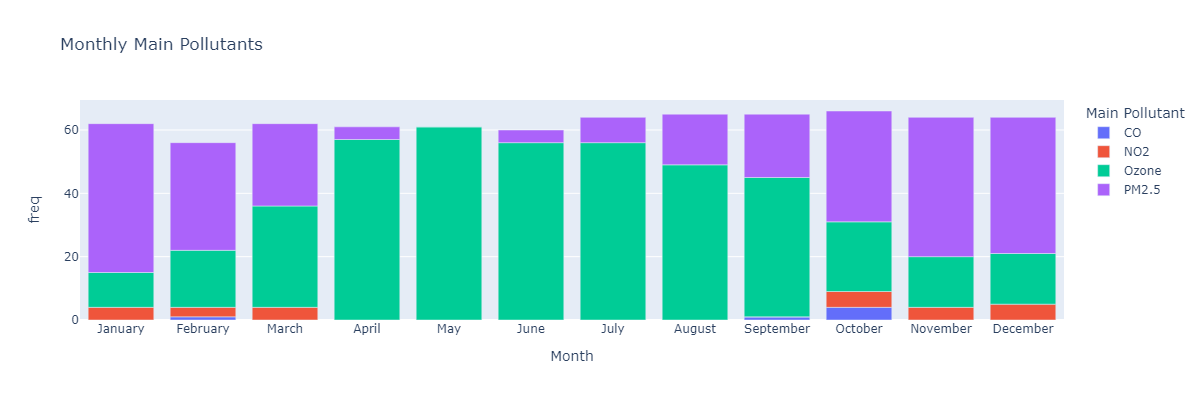

In [235]:
fig = px.bar(melted_month_pollutant_freq, x='Month',y='freq', color='Main Pollutant', title='Monthly Main Pollutants')
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

---
Continuous variables’ multicollinearity will be assessed with Spearman correlation and Variance Inflation Factors


---
ILI cases will be modeled with months alone and with months + other variables to explore the impact of the other variables on cases.


---
The stationarity of ILI cases will be tested using the Adfuller Test of Stationarity. If the series fails to show stationarity, another Adfuller test will be performed on the first-differenced data.


---
If the cases series or its first-differenced transformation are indeed stationary, an autoregression model will be developed to explore any lagged-effects of past weeks in the data.


---
Delayed-effects of independent variables on ILI cases will be explored with cross-correlation plots to select lagged terms which may have an influence on cases. 


---
These lagged terms will be included in a multiple linear regression model, alongside auto-lags, months, and other terms
